# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">3 hours</span>
* 2. Part B: <span style="color:red;">30 minutes</span>
* 3. Part C: <span style="color:red;">6 hours</span>
* 4. Tests: <span style="color:red;">30 minutes</span>
* 5. Challenge 1: <span style="color:red;">5 minutes</span>
* 6. Challenge 2: <span style="color:red;">1 hour</span>
* 7. Write-up: <span style="color:red;">10 minutes</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [88]:
%pylab inline
from PIL import Image
import numba
from scipy import ndimage
from skimage.transform import warp

Populating the interactive namespace from numpy and matplotlib


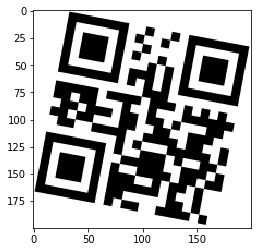

In [120]:
image = array(Image.open("QR_codes/test2.png").convert("L")).astype(float)
imshow(image, cmap="gray")

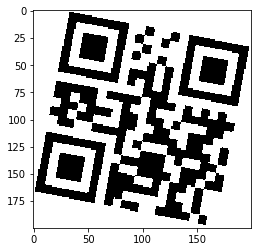

In [121]:
# Preprocessing
def binary(image, threshold=0.7, quick=False):
    if quick:
        return image > threshold * image.mean()
    else:
        blur_size = (image.shape[0] * image.shape[1]) ** 0.5 / 20
        gaussian_blur = ndimage.gaussian_filter(image, blur_size, mode="nearest", cval=image.max())
        return image > threshold * gaussian_blur

binary_image = binary(image)
imshow(binary_image, cmap="gray")

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [122]:
def find_centers_horizontal(image):
    # Computes centers of corners that work in the horizontal direction for a QR code
    height, width = image.shape
    centers = zeros(image.shape)
    
    for y in range(height):
        white_lengths = [0, 0]
        black_lengths = [0, 0, 0]
        on_white = True
        
        for x in range(width):
            if bool(image[y][x]) != on_white:
                on_white ^= True
                if on_white:
                    length = (sum(white_lengths) + sum(black_lengths)) / 7
                    if (abs(length - white_lengths[0]) / length < 0.3 and
                        abs(length - white_lengths[1]) / length < 0.3 and
                        abs(length - black_lengths[0]) / length < 0.3 and
                        abs(length - black_lengths[2]) / length < 0.3 and
                        abs(length * 3 - black_lengths[1]) / length < 0.9):
                        centers[y][int(round(x - length*3.5) - 1)] = 1
                    white_lengths = white_lengths[1:] + [0]
                else:
                    black_lengths = black_lengths[1:] + [0]
            if on_white:
                white_lengths[-1] += 1
            else:
                black_lengths[-1] += 1
                
        x = width
        on_white ^= True
        if on_white:
            length = (sum(white_lengths) + sum(black_lengths)) / 7
            if (abs(length - white_lengths[0]) / length < 0.3 and
                abs(length - white_lengths[1]) / length < 0.3 and
                abs(length - black_lengths[0]) / length < 0.3 and
                abs(length - black_lengths[2]) / length < 0.3 and
                abs(length * 3 - black_lengths[1]) / length < 0.9):
                centers[y][int(round(x - length*3.5) - 1)] = 1
    return centers
            

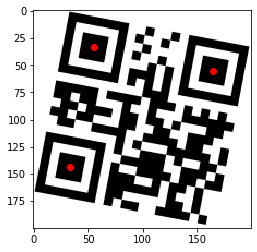

In [123]:
def total_centers(image, rotations=16):
    shape = image.shape
    result = zeros(image.shape)
    for i in range(rotations):
        rotated_image = ndimage.rotate(image, 180 * i / rotations, cval=255)
        binary_image = binary(rotated_image)
        centers = find_centers_horizontal(binary_image)
        centers = ndimage.rotate(centers, -180 * i / rotations, cval=0, order=1)
        new_shape = centers.shape
        dy, dx = new_shape[0] - shape[0], new_shape[1] - shape[1]
        final_centers = centers[dy//2 : shape[0] + dy//2, dx//2 : shape[1] + dx//2]
        result += final_centers
    return result

def find_corner_centers(image, rotations=16, filter_size=None):
    filter_size = filter_size or (image.shape[0] * image.shape[1])**0.5 / 10
    centers = total_centers(image, rotations)
    maximum_centers = ndimage.maximum_filter(centers, size=filter_size)
    centers[centers != maximum_centers] = 0
    best_indexes = np.argpartition(centers.flatten(), -3)[-3:]
    ys, xs = np.unravel_index(best_indexes, centers.shape)
    return [array([x, y]) for x, y in zip(xs, ys)]

centers = find_corner_centers(image, 8)
imshow(image, cmap="gray")
xs, ys = zip(*centers)
plt.scatter(xs, ys, c='r')

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [124]:
def create_homography(start_points, end_points):
    """
    Usage:  computes a homography of start points to end points.  Each must be a list of at least 4 points. If
            the number of points is greater than 4, a least squares solution will be returned.
    """
    A = np.concatenate([[
        [start_point[0], start_point[1], 1, 0, 0, 0, -end_point[0]*start_point[0], -end_point[0]*start_point[1]],
        [0, 0, 0, start_point[0], start_point[1], 1, -end_point[1]*start_point[0], -end_point[1]*start_point[1]]
    ] for start_point, end_point in zip(start_points, end_points)])
    
    b = np.concatenate([[x, y] for x, y in end_points])[None].T
    
    if b.size != 8:
        A, b = np.matmul(A.T, A), np.matmul(A.T, b)
    
    H = np.matmul(np.linalg.inv(A), b)
    H = np.append(H, 1)
    H = H.reshape((3, 3))
    
    return H

[array([ 33, 144], dtype=int64), array([55, 33], dtype=int64), array([165,  55], dtype=int64)]


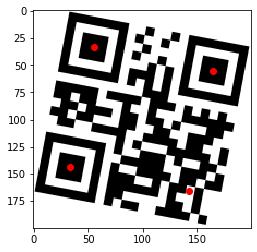

In [125]:
def order_corners(corner1, corner2, corner3):
    # Return the corners in clockwise order, starting at the most counter-clockwise.
    d3, d1, d2 = corner1 - corner2, corner2 - corner3, corner3 - corner1
    a3, a1, a2 = sum(d1 * d2), sum(d2 * d3), sum(d3 * d1)
    b1, b2, b3 = abs(a1), abs(a2), abs(a3)
    m = min(b1, b2, b3)
    if m == b1:
        middle, left, right = corner1, corner2, corner3
    elif m == b2:
        middle, left, right = corner2, corner3, corner1
    else:
        middle, left, right = corner3, corner1, corner2
    x1, x2 = left - middle, right - middle
    if x1[0] * x2[1] > x1[1] * x2[0]:
        left, right = right, left
    return [left, middle, right]

def find_fourth_point(corner1, corner2, corner3):
    return corner1 + corner3 - corner2

centers = order_corners(*centers)
print(centers)
fourth_point = find_fourth_point(*centers)
all_centers = centers + [fourth_point]
xs, ys = zip(*all_centers)
imshow(image, cmap="gray")
scatter(xs, ys, c='r')

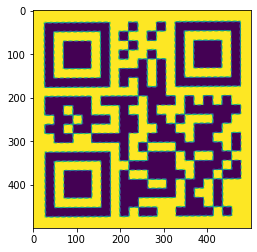

In [126]:
H = create_homography(all_centers, [(100, 400), (100, 100), (400, 100), (400, 400)])
warped_image = warp(image, np.linalg.inv(H), output_shape=(500, 500), cval=255)
imshow(warped_image)

21


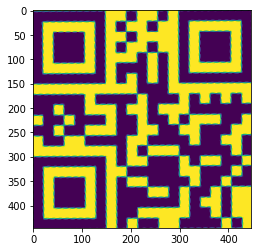

In [127]:
def crop(warped_image):
    discrete_image = binary(warped_image)
    
    length = 0
    middle = array((100, 100))
    while not discrete_image[middle[0], middle[1]]:
        middle -= (1, 1)
        length += 1
    while discrete_image[middle[0], middle[1]]:
        middle -= (1, 1)
        length += 1
    while not discrete_image[middle[0], middle[1]]:
        middle -= (1, 1)
        length += 1
    topleft = middle
    
    middle = array((400, 100))
    while not discrete_image[middle[0], middle[1]]:
        middle += (1, -1)
        length += 1
    while discrete_image[middle[0], middle[1]]:
        middle += (1, -1)
        length += 1
    while not discrete_image[middle[0], middle[1]]:
        middle += (1, -1)
        length += 1
    bottomleft = middle
    
    middle = array((100, 400))
    while not discrete_image[middle[0], middle[1]]:
        middle += (-1, 1)
        length += 1
    while discrete_image[middle[0], middle[1]]:
        middle += (-1, 1)
        length += 1
    while not discrete_image[middle[0], middle[1]]:
        middle += (-1, 1)
        length += 1
    topright = middle
    
    top, left, bottom, right = min(topleft[0], topright[0]), min(topleft[1], bottomleft[1]), bottomleft[0], topright[1]
    return warped_image[top:bottom, left:right], int(round((((bottom - top) * (right - left)) ** 0.5 / length * 10.5 - 1) / 4)) * 4 + 1

cropped_image, size = crop(warped_image)
print(size)
imshow(cropped_image)

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


(21, 21)


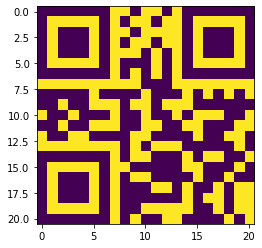

In [128]:
def discretize(image, size):
    height, width = image.shape
    result = zeros((size, size))
    for y in range(size):
        for x in range(size):
            y1, y2 = int(round(y * height / size)), int(round((y + 1) * height / size))
            x1, x2 = int(round(x * width / size)), int(round((x + 1) * width / size))
            result[y, x] = np.mean(image[y1 : y2, x1 : x2]) > 0.5
    return result

discrete_image = discretize(binary(cropped_image, threshold=1), size)
imshow(discrete_image)
print(discrete_image.shape)

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [129]:
print(decode(discrete_image))

http://byu.edu


In [98]:
from decoder import decode

def process_to_discrete(image):
    start = time.time()
    centers = find_corner_centers(image, rotations=8)
    centers = order_corners(*centers)
    centers.append(find_fourth_point(*centers))
    H = create_homography(centers, [(100, 400), (100, 100), (400, 100), (400, 400)])
    warped_image = warp(image, np.linalg.inv(H), output_shape=(500, 500), cval=255)
    cropped_image, size = crop(warped_image)
    discrete_image = discretize(binary(cropped_image, threshold=1), size)
    end = time.time()
    print("Time took = " + str(end - start) + " seconds")
    return discrete_image

def decode_image(image):
    discrete_image = process_to_discrete(image)
    return decode(discrete_image)

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

Time took = 0.5794754028320312 seconds
Time took = 0.599445104598999 seconds
Time took = 0.6482691764831543 seconds
Time took = 0.5704500675201416 seconds
Time took = 0.807863712310791 seconds


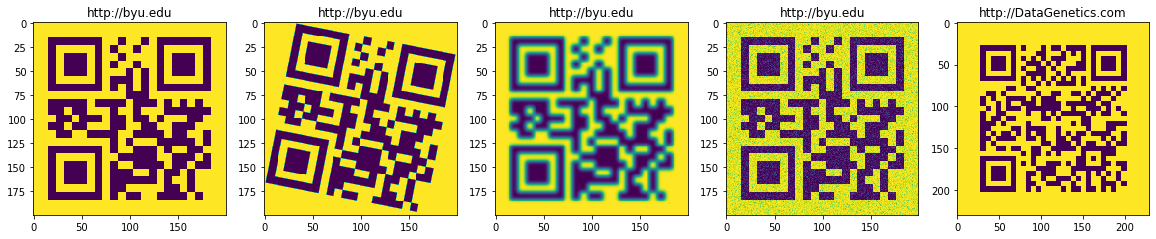

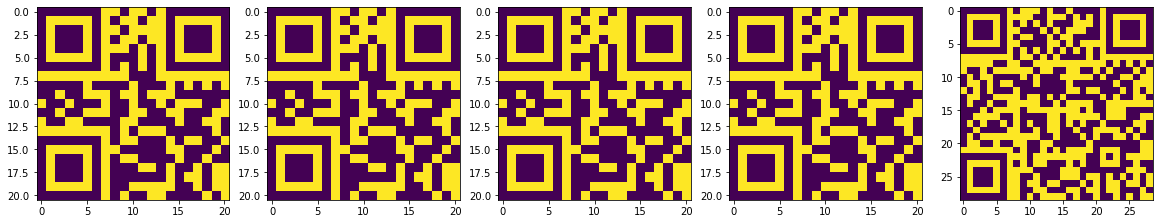

In [119]:
images = [array(Image.open(path).convert("L")).astype(float) for path in (
    "QR_codes/test1.png",
    "QR_codes/test2.png",
    "QR_codes/test3.png",
    "QR_codes/test4.png",
    "QR_codes/test5.png",
)]

ax, fig = subplots(1, len(images), figsize=(20, 5))
ax2, fig2 = subplots(1, len(images), figsize=(20, 5))
for i, image in enumerate(images):
    fig[i].imshow(image)
    discrete_image = process_to_discrete(image)
    fig2[i].imshow(discrete_image)
    try:
        fig[i].title.set_text(decode(discrete_image))
    except Exception as e:
        fig[i].title.set_text("ERROR")

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



Time took = 0.5714704990386963 seconds
Time took = 1.2466645240783691 seconds
Time took = 0.9364628791809082 seconds


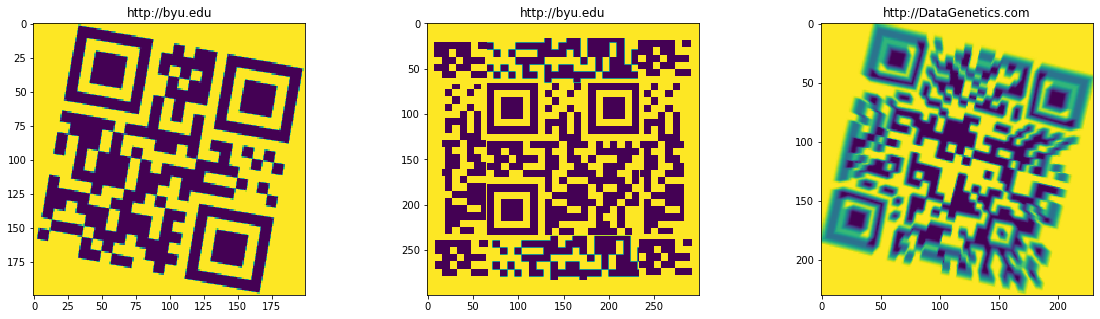

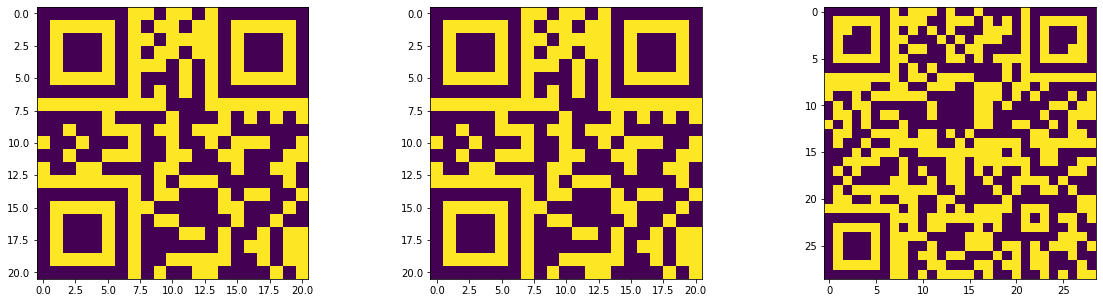

In [114]:
images = [array(Image.open(path).convert("L")).astype(float) for path in (
    "QR_codes/challenge1.png",
    "QR_codes/challenge3.png",
    "QR_codes/challenge4.png",
)]

ax, fig = subplots(1, len(images), figsize=(20, 5))
ax2, fig2 = subplots(1, len(images), figsize=(20, 5))
for i, image in enumerate(images):
    fig[i].imshow(image)
    discrete_image = process_to_discrete(image)
    fig2[i].imshow(discrete_image)
    try:
        fig[i].title.set_text(decode(discrete_image))
    except Exception as e:
        fig[i].title.set_text("ERROR")


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

It's a bit hard to decide what the most difficult part of the lab was.  I felt it was all pretty hard.  If I had to choose one part to be the most difficult, it would be discretizing the
QR code.  What made this section especially hard was that in order to get a decent result, one needed to first crop the warped image apropriately, and then one needed to also check the timing information, which would sometimes not work due to error, especially in the blurry images.  I eventually figured out a way to crop the image and at the same time determine the size of the QR code, which helped tremendously to solve this problem.

Challenge 1:  Rotated QR code.  There is nothing special about a QR code being rotated more than 90 degrees, so this was basically free points.  To find which of the three center points found belonged in the top left, I found which one minimized the squared distance to the others.  (Actually, I used some dot products, but the math works out to be equivalent.)

Challenge 3:  Noise around the QR code.  To do this challenge, I needed to find the corners of the QR code.  To do so, I had a point that I placed in each of the three centers of the squares after warping, and then moved these points outward towards the corners until they hit three transitions from dark to light or vice versa.  Where these points ended up were the corners of the QR code.

Challenge 4:  Extreme blurriness.  This required some luck and tweaking to my algorithms.  I needed a robust way to discretize the image and threshold the image.  To threshold the image, I used a Gaussian blur to compare each pixel to the surrounding pixels to determine if it was light or dark.  To discretize the image, I first thresholded it in order to remove most of the blurriness and I then discretized it.  The result was fairly good, but did have many mroe errors than any of the other images.

Improvements:  The website used to decode the binary arrays of pixels was not very good and would often throw errors when running.  An alternative method to decode the QR codes at this stage should be found in the future.